# Takeaways
- Maintain separate payloads for api vs. mobile
    - Faster to read/write .parquet + .npy, but only api can use those
    - Mobile needs to use .sqlite + files (.png, .mp4), but it's slower for both read and write
- TODO Still more room to compress mobile payloads
    - 71% of payload: audio
        - Can be cut in ~half if we can drop 32k -> 16k (maybe with aac_he?)
            - Android supports HE-AACv2: https://developer.android.com/guide/topics/media/media-formats
            - But ios doesn't? https://apple.co/2NORQHB
        - Payload 1.98g -> ~1.28g -- ✅ ~35% of payload
    - 21% of payload: spectro
        - Not much excess: maybe ~5% of spectros (see notebooks/spectro_img_encode)
        - Payload 1.98g -> ~1.96g -- ❌ ~1% of payload
    - 5.9% of payload: f_preds_* sqlite cols (n_sp=331)
        - (Based on: 119m = 164m with - 45m without)
        - No float32 in sqlite, only float64 [❓ Unless we get clever and pack into int32/int16, or blob...]
            - [e.g. blob: https://github.com/SeanTater/sqlite3-extras]
        - Can pca compress, but can't achieve more than a few % of payload
        - Payload 1.98g -> ~1.98g with n_components=331 -- min ~0% of payload
        - Payload 1.98g -> ~1.93g with n_components=150 --  🔶 ~3% of payload
        - Payload 1.98g -> ~1.90g with n_components=100 --  🔶 ~4% of payload
        - Payload 1.98g -> ~1.86g with n_components=10  --  🔶 ~6% of payload
        - Payload 1.98g -> ~1.86g with n_components=0   -- max ~6% of payload
    - 2.2% of payload: rest of sqlite cols
        - Max ~2% of payload -- ❌ low ROI

In [ ]:
from notebooks import *
sg.init(None, skip=[sg_load.load_search_recs])
get_search_recs.cache_clear()

INFO     [19:37:39.461] [ 4535] 151 logging_/<module>: {logging_yaml: None}

INFO     [19:37:39.891] [ 4535]  32 api.server_globals/init

DEBUG    [19:37:39.897] [ 4535]  75 api.server_globals/load: load_search...

INFO     [19:37:40.193] [ 4535]  79 api.server_globals/load: load_search (took 0.289s)

DEBUG    [19:37:40.200] [ 4535]  75 api.server_globals/load: load_xc_meta...

INFO     [19:37:40.541] [ 4535]  79 api.server_globals/load: load_xc_meta (took 0.335s)

DEBUG    [19:37:40.549] [ 4535]  75 api.server_globals/load: load_feat_info...

INFO     [19:37:40.555] [ 4535] 110 api.server_globals/load_feat_info

INFO     [19:37:40.563] [ 4535]  79 api.server_globals/load: load_feat_info (took 0.008s)

WARNING  [19:37:40.570] [ 4535]  73 api.server_globals/load: load_search_recs [skipped]

INFO     [19:37:40.576] [ 4535]  34 api.server_globals/init: done

# Perf notes

Before
- Cold cache (warm pagecache but cold python proc)
```
search_recs(**{'cache_type': 'hybrid'})
...
DEBUG    [12:58:26.994] [37904] 119 payloads/df_cache_hybrid: Hit [start]
DEBUG    [12:58:27.001] [37904] 129 payloads/df_cache_hybrid: Hit: Reading non_feats.parquet (1.8 GB)
INFO     [12:58:32.028] [37904] 136 payloads/df_cache_hybrid: Hit: Read non_feats.parquet (1.8 GB)
DEBUG    [12:58:32.040] [37904] 141 payloads/df_cache_hybrid: Hit: Reading feat-f_preds.npy (46.6 MB)
INFO     [12:58:32.077] [37904] 143 payloads/df_cache_hybrid: Hit: Read feat-f_preds.npy: float32 (46.6 MB)
DEBUG    [12:58:32.084] [37904] 141 payloads/df_cache_hybrid: Hit: Reading feat-feat.npy (211.4 MB)
INFO     [12:58:32.211] [37904] 143 payloads/df_cache_hybrid: Hit: Read feat-feat.npy: float32 (211.4 MB)
INFO     [12:58:32.218] [37904] 147 payloads/df_cache_hybrid: Hit: Join non_feats + feats
INFO     [12:58:32.469] [37904] 155 payloads/df_cache_hybrid: Hit [5.475s]
```

search_recs(**{'cache_type': 'hybrid'})

INFO     [19:37:40.778] [ 4535] 601 api.recs/get_search_recs

INFO     [19:37:40.794] [ 4535] 152 payloads/df_cache_hybrid: Hit: payloads/search_recs-version[8],audio_s[10],countries_k[na],com_names_k[ca],num_recs[None]-c292d6b

INFO     [19:37:42.616] [ 4535] 169 payloads/df_cache_hybrid: Hit: Read api/lite.parquet (51.0 MB) [1.806s]

INFO     [19:37:50.159] [ 4535] 181 payloads/df_cache_hybrid: Hit: Read api/bytes-audio_bytes.parquet (1.4 GB) [7.524s]

INFO     [19:37:51.060] [ 4535] 181 payloads/df_cache_hybrid: Hit: Read api/bytes-spectro_bytes.parquet (382.8 MB) [0.796s]

INFO     [19:37:51.114] [ 4535] 188 payloads/df_cache_hybrid: Hit: Read api/feat-f_preds.npy (46.6 MB) [float32, 0.037s]

INFO     [19:37:51.285] [ 4535] 188 payloads/df_cache_hybrid: Hit: Read api/feat-feat.npy (211.4 MB) [float32, 0.158s]

INFO     [19:37:51.292] [ 4535] 191 payloads/df_cache_hybrid: Hit: Join lite + bytes + feats

INFO     [19:37:51.913] [ 4535] 202 payloads/df_cache_hybrid: Hit [11.109s]

INFO     [19:37:53.382] [ 4535] 244 payloads/df_cache_hybrid: Mobile: Add columns for mobile [1.437s]

Mobile: Ensure dirs: audio_bytes: [

] |   0% (334) |  0.0s

Mobile: Ensure dirs: audio_bytes: [

##############################################################

] | 100% (334) |  0.1s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.0s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.2s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.3s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.4s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.5s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.6s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.8s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  0.9s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  1.0s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  1.1s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  1.2s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  1.3s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  1.5s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  1.6s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  1.7s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  1.8s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  1.9s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  2.0s

Mobile: Write files: audio_bytes: [

] |   0% (35231) |  2.2s

Mobile: Write files: audio_bytes: [

##########                                                  

] |  17% (35231) |  2.3s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  2.4s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  2.5s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  2.6s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  2.7s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  2.9s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  3.0s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  3.1s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  3.2s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  3.3s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  3.4s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  3.6s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  3.7s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  3.8s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  3.9s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  4.0s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  4.1s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  4.2s

Mobile: Write files: audio_bytes: [

############                                                

] |  20% (35231) |  4.4s

Mobile: Write files: audio_bytes: [

################                                            

] |  27% (35231) |  4.5s

Mobile: Write files: audio_bytes: [

######################                                      

] |  37% (35231) |  4.6s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  4.7s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  4.8s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  4.9s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  5.1s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  5.2s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  5.3s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  5.4s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  5.5s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  5.6s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  5.7s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  5.9s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  6.0s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  6.1s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  6.2s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  6.3s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  6.4s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  6.5s

Mobile: Write files: audio_bytes: [

########################                                    

] |  40% (35231) |  6.7s

Mobile: Write files: audio_bytes: [

###########################                                 

] |  45% (35231) |  6.8s

Mobile: Write files: audio_bytes: [

##############################                              

] |  50% (35231) |  6.9s

Mobile: Write files: audio_bytes: [

##################################                          

] |  57% (35231) |  7.0s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  7.1s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  7.2s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  7.4s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  7.5s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  7.6s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  7.7s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  7.8s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  7.9s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  8.0s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  8.2s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  8.3s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  8.4s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  8.5s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  8.6s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  8.7s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  8.9s

Mobile: Write files: audio_bytes: [

####################################                        

] |  60% (35231) |  9.0s

Mobile: Write files: audio_bytes: [

#####################################                       

] |  62% (35231) |  9.1s

Mobile: Write files: audio_bytes: [

##########################################                  

] |  70% (35231) |  9.2s

Mobile: Write files: audio_bytes: [

#############################################               

] |  76% (35231) |  9.3s

Mobile: Write files: audio_bytes: [

##############################################              

] |  77% (35231) |  9.4s

Mobile: Write files: audio_bytes: [

################################################            

] |  80% (35231) |  9.6s

Mobile: Write files: audio_bytes: [

################################################            

] |  80% (35231) |  9.7s

Mobile: Write files: audio_bytes: [

################################################            

] |  80% (35231) |  9.8s

Mobile: Write files: audio_bytes: [

################################################            

] |  80% (35231) |  9.9s

Mobile: Write files: audio_bytes: [

################################################            

] |  80% (35231) | 10.0s

Mobile: Write files: audio_bytes: [

################################################            

] |  80% (35231) | 10.1s

Mobile: Write files: audio_bytes: [

################################################            

] |  80% (35231) | 10.3s

Mobile: Write files: audio_bytes: [

################################################            

] |  80% (35231) | 10.4s

Mobile: Write files: audio_bytes: [

################################################            

] |  80% (35231) | 10.5s

Mobile: Write files: audio_bytes: [

################################################            

] |  80% (35231) | 10.6s

Mobile: Write files: audio_bytes: [

################################################            

] |  80% (35231) | 10.7s

Mobile: Write files: audio_bytes: [

################################################            

] |  80% (35231) | 10.8s

Mobile: Write files: audio_bytes: [

################################################            

] |  80% (35231) | 10.9s

Mobile: Write files: audio_bytes: [

################################################            

] |  80% (35231) | 11.1s

Mobile: Write files: audio_bytes: [

################################################            

] |  80% (35231) | 11.2s

Mobile: Write files: audio_bytes: [

#################################################           

] |  82% (35231) | 11.3s

Mobile: Write files: audio_bytes: [

##################################################          

] |  83% (35231) | 11.4s

Mobile: Write files: audio_bytes: [

############################################################

] | 100% (35231) | 11.5s

Mobile: Ensure dirs: spectro_bytes: [

] |   0% (334) |  0.0s

Mobile: Ensure dirs: spectro_bytes: [

############################################################

] | 100% (334) |  0.1s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.0s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.2s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.3s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.4s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.5s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.6s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.7s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  0.8s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.0s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.1s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.2s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.3s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.4s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.5s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.6s

Mobile: Write files: spectro_bytes: [

] |   0% (35231) |  1.7s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  1.8s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.0s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.1s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.2s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.3s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.4s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.5s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.6s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.7s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.8s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  2.9s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  3.1s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  3.2s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  3.3s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  3.4s

Mobile: Write files: spectro_bytes: [

###########                                               

] |  20% (35231) |  3.5s

Mobile: Write files: spectro_bytes: [

##################                                        

] |  31% (35231) |  3.6s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  3.7s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  3.8s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  3.9s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.1s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.2s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.3s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.4s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.5s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.6s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.8s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  4.9s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  5.0s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  5.1s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  5.2s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  5.3s

Mobile: Write files: spectro_bytes: [

#######################                                   

] |  40% (35231) |  5.4s

Mobile: Write files: spectro_bytes: [

#################################                         

] |  57% (35231) |  5.5s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  5.7s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  5.8s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  5.9s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  6.0s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  6.1s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  6.2s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  6.3s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  6.4s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  6.6s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  6.7s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  6.8s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  7.0s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  7.1s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  7.2s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  7.3s

Mobile: Write files: spectro_bytes: [

##################################                        

] |  60% (35231) |  7.4s

Mobile: Write files: spectro_bytes: [

##########################################                

] |  72% (35231) |  7.5s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  7.6s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  7.7s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  7.9s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  8.0s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  8.1s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  8.2s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  8.3s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  8.4s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  8.5s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  8.6s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  8.8s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  8.9s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  9.0s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  9.1s

Mobile: Write files: spectro_bytes: [

##############################################            

] |  80% (35231) |  9.2s

Mobile: Write files: spectro_bytes: [

#####################################################     

] |  92% (35231) |  9.3s

Mobile: Write files: spectro_bytes: [

##########################################################

] | 100% (35231) |  9.4s

INFO     [19:38:34.629] [ 4535] 286 payloads/df_cache_hybrid: Mobile: Expand feat col: f_preds (331) [5.155s]

INFO     [19:38:35.023] [ 4535] 298 payloads/df_cache_hybrid: Mobile: Norm feat col: f_preds [0.379s]

INFO     [19:38:35.416] [ 4535] 329 payloads/<dictcomp>: Mobile: Covert non-sql col: json_dumps_canonical(background) (35231) [0.171s]

INFO     [19:38:35.594] [ 4535] 329 payloads/<dictcomp>: Mobile: Covert non-sql col: json_dumps_canonical(background_species) (35231) [0.163s]

INFO     [19:38:58.735] [ 4535] 361 payloads/df_cache_hybrid: Mobile: Write mobile-version[1]/search_recs/search_recs.sqlite3 [168.0 MB, 23.056s]

INFO     [19:38:58.751] [ 4535] 371 payloads/df_cache_hybrid: Mobile: Write mobile-version[1]/search_recs/server-config.json [2.2 kB, 0.002s]

INFO     [19:38:58.773] [ 4535] 392 payloads/_npy: Mobile: Write mobile-version[1]/search_recs/models/projection.skm_.D.npy [420.1 kB, 0.003s]

INFO     [19:38:58.786] [ 4535] 392 payloads/_npy: Mobile: Write mobile-version[1]/search_recs/models/projection.skm_.pca.mean_.npy [1.4 kB, 0.001s]

INFO     [19:38:58.800] [ 4535] 392 payloads/_npy: Mobile: Write mobile-version[1]/search_recs/models/projection.skm_.pca.components_.npy [134.5 kB, 0.001s]

INFO     [19:38:58.811] [ 4535] 392 payloads/_npy: Mobile: Write mobile-version[1]/search_recs/models/projection.skm_.pca.explained_variance_.npy [968 B, 0.001s]

INFO     [19:38:58.866] [ 4535] 392 payloads/_npy: Mobile: Write mobile-version[1]/search_recs/models/classifier_._coef_arr.npy [4.0 MB, 0.006s]

INFO     [19:38:58.909] [ 4535] 392 payloads/_npy: Mobile: Write mobile-version[1]/search_recs/models/classifier_._intercept_arr.npy [2.8 kB, 0.001s]

INFO     [19:38:58.923] [ 4535] 446 payloads/df_cache_hybrid: Mobile: Write mobile-version[1]/search_recs/models/search.json [4.9 kB, 0.159s]

INFO     [19:38:58.933] [ 4535] 446 payloads/df_cache_hybrid: Mobile: Write payload [67.007s]

,dir,file,size,frac
5,api,TOTAL,2104306229,1.000
1,api,api/bytes-audio_bytes.parquet,1412454635,0.671
2,api,api/bytes-spectro_bytes.parquet,382833212,0.182
4,api,api/feat-feat.npy: float32,211386128,0.100
0,api,api/lite.parquet,50986282,0.024
3,api,api/feat-f_preds.npy: float32,46645972,0.022
9,mobile-version[1],TOTAL,2120306688,1.000
6,mobile-version[1],mobile-version[1]/search_recs/audio/,1502609408,0.709
7,mobile-version[1],mobile-version[1]/search_recs/spectro/,449687552,0.212
8,mobile-version[1],mobile-version[1]/search_recs/search_recs.sqlite3,168009728,0.079


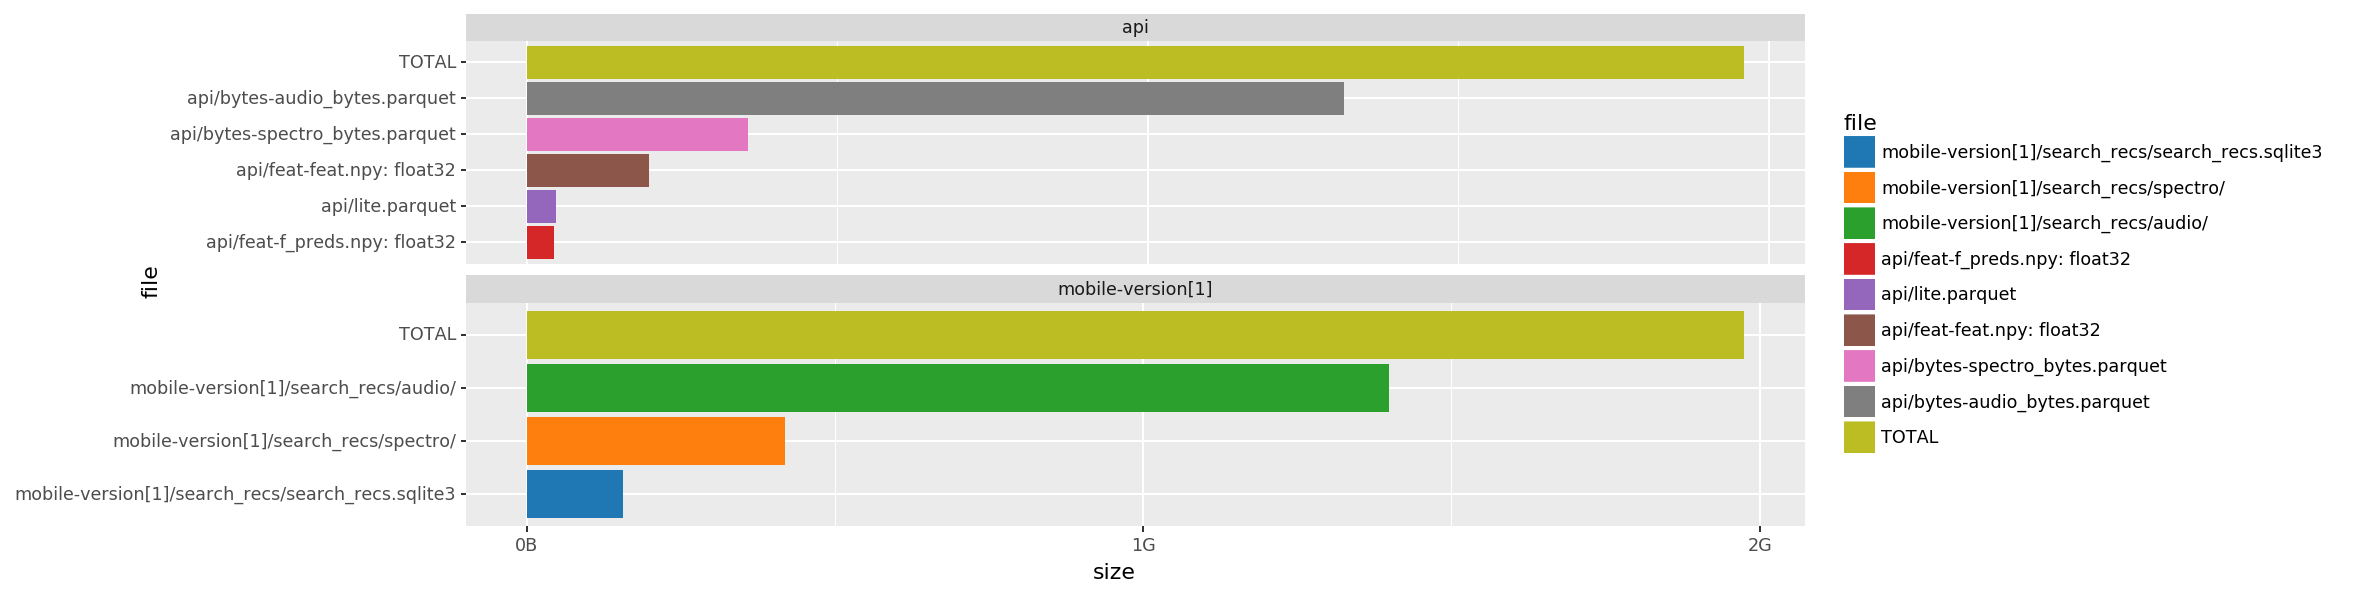

<ggplot: (413732153)>

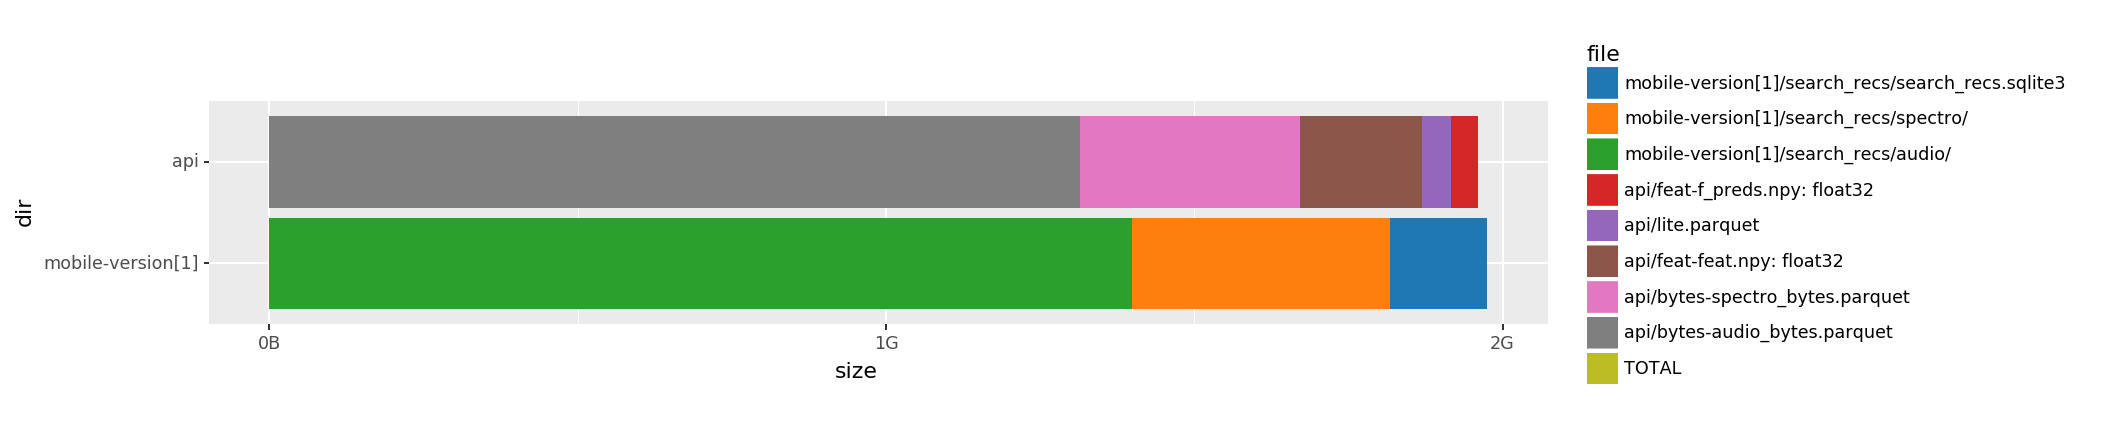

<ggplot: (-9223372036582375182)>

,size,type,0
xc_id,36,int,413174
feat,104,ndarray,[ 9.259e-02 -3.927e-02 4.972e-01 -4.154e-04 -4.900e-02 -6.117e-02 3.974e-02 -1.629e-01 6.649e-02 -1.643e-02 -8.081e-02 -7.604e-02 -9.098e-02 4.766e-02 -4.830e-02 -6.90...
f_preds,104,ndarray,[3.219e-03 1.693e-03 4.284e-05 3.685e-03 1.657e-03 1.457e-02 9.939e-03 1.444e-03 2.617e-04 6.943e-04 4.435e-04 7.072e-04 2.569e-03 9.745e-03 8.396e-04 2.003e-03 7.801e-04 ...
background,80,list,['White-crowned Sparrow (Zonotrichia leucophrys)']
background_species,80,list,['WCSP']


In [ ]:
log_levels({
    'payloads': 'INFO',
    # 'payloads': 'DEBUG',
})
kwargss = [
    # dict(cache_type='hybrid', refresh=True),  # Simulate cache miss
    dict(cache_type='hybrid'),                # Simulate cache hit
]
search_recss = []
for i, kwargs in enumerate(kwargss):
    if i > 0: print()
    print(f'search_recs(**{kwargs})')
    get_search_recs.cache_clear()
    search_recs = get_search_recs(**kwargs,
        write_mobile_payload=True,
        plot_sizes=True,
    )
    search_recss.append(search_recs)
    display(search_recs
        [['xc_id', 'feat', 'f_preds', 'background', 'background_species']]
        [2:3].reset_index(drop=True).T
        .pipe(df_assign_first,
            size=lambda df: df.T.memory_usage(deep=True),
            type=lambda df: df[0].map(lambda x: type(x).__name__),
        )
    )

In [ ]:
# TODO Turn this into unit tests
#   - Should roundtrip, should preserve category dtypes, should fail if index present
assert len(search_recss) == 2, "Test requires both 'cache hit' + 'cache miss' to be uncommented (above)"
[a, b] = search_recss
pd.testing.assert_frame_equal(a, b, check_column_type=True,
    check_index_type=False,  # Allow Int64Index vs. RangeIndex
)

[skip]